In [8]:
# Import functions and libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import scipy
import cv2

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc
from scipy import fftpack
import math
import matplotlib.pylab as pylab
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

DEBUG = False
# Reading Image
im = cv2.imread("original_image.jpg",1)

# Splitting into Red, Green, Blue channel
b,g,r= cv2.split(im)


def dct2(a):
    x =  scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )
    return x

imsize = r.shape
dct_r = np.zeros(imsize)
dct_g = np.zeros(imsize)
dct_b = np.zeros(imsize)


# 8 X 8 dct of 64 pixels.
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct_r[i:(i+8),j:(j+8)] = dct2(r[i:(i+8),j:(j+8)] )
        dct_g[i:(i+8),j:(j+8)] = dct2(g[i:(i+8),j:(j+8)] )
        dct_b[i:(i+8),j:(j+8)] = dct2(b[i:(i+8),j:(j+8)] )


thresh = 0.4
# Removing numbers less than threshold * max(color plane)
def thresholding(x):
    x =  x * (abs(x) > (thresh*np.max(x)))
    return x

# Thresholding of channels
dct_r = thresholding(dct_r)
dct_b = thresholding(dct_b)
dct_g = thresholding(dct_g)


# Runlength encoding generator in zig-zag for 8X8 matrix
def run_len():
    i,j = 0,0
    up = True
    while True:
        yield (i,j)
        if i==j==7:
            break
        if up:
            if i==0 and j!=7:
                j+=1
                up = False
            elif j==7 and i!=7:
                i+=1
                up = False
            elif (j!=7 and i!=0):
                i-=1
                j+=1
        else:
            if j==0 and i!=7:
                i+=1
                up = True
            elif i==7 and j!=7:
                j+=1
                up = True
            elif (j!=0 and i!=7):
                j-=1
                i+=1
    yield 0

def compress_block(x):
    gen = run_len()
    old = None
    cnt=1
    # 0 padding on left and bottom
    y = np.zeros((8,8))
    y[:len(x),:len(x[0])] = x
    x = y
    # run-len encoding using the index returned by run_len generator.
    fin = []
    for i in range(8):
        for j in range(8):
            a,b = next(gen)
            num = int(x[a][b])
            if (old != num):
                fin.append((old, cnt))
                cnt = 1
                old = num
            else:
                cnt+=1
    fin.append((old, cnt))
    # Removing the first data as it is initilized with None
    return fin[1:]

def print_sample():
    print("Random 8X8 block\n")
    x = r[204:212, 204:212]
    print(x,'\n')

    print("DCT of the block which removes high frequency components\n")
    x = dct2(x)
    print(x,'\n')

    print("DCT after thresholding with thresholding at 0.04\n")
    x = thresholding(x)
    print(x,'\n')

    print("Run length coding output for the block")
    x = compress_block(x)
    print(x,'\n')
if DEBUG:
    print_sample()
print("Doing run length coding")
# compresssion of 8X8 blocks
red = []
green = []
blue = []
for i in r_[:imsize[0]:8]:
    r_block = []
    g_block = []
    b_block = []
    for j in r_[:imsize[1]:8]:
        r_block.append(compress_block(dct_r[i:(i+8),j:(j+8)]))
        g_block.append(compress_block(dct_g[i:(i+8),j:(j+8)]))
        b_block.append(compress_block(dct_b[i:(i+8),j:(j+8)]))
    red.append(r_block)
    green.append(g_block)
    blue.append(b_block)
# converting array to string and removing "(", ")" and space.
print("Run length coding completed")

if DEBUG:
    with open("r.txt","w") as f:
        f.write(str(red).replace("(","").replace(")","").replace(" ",""))

red = str(red).replace("(","").replace(")","").replace(" ","")
green = str(green).replace("(","").replace(")","").replace(" ","")
blue = str(blue).replace("(","").replace(")","").replace(" ","")

# Huffman encoding for channel compression
def compress_channel(channel_data, file_name):

    # Huffman encoding start
    symbol_dict = {}
    class node:
        def __init__(self, freq, symbol, left=None, right=None):
            self.freq = freq
            self.symbol = symbol
            self.left = left
            self.right = right
            self.huff = ''

    def printNodes(node, val=''):
        newVal = val + str(node.huff)
        if(node.left):
            printNodes(node.left, newVal)
        if(node.right):
            printNodes(node.right, newVal)
        if(not node.left and not node.right):
            print(f"{node.symbol} -> {newVal}")
            symbol_dict[node.symbol] = newVal

    unique_char = set(channel_data)
    counter = {}
    for char in unique_char:
        counter[char] = channel_data.count(char)

    chars = [ i for i in counter]
    freq = [counter[i] for i in counter]
    nodes = []
    total = sum(freq)
    for x in range(len(chars)):
        nodes.append(node(freq[x], chars[x]))

    while len(nodes) > 1:
        nodes = sorted(nodes, key=lambda x: x.freq)
        left = nodes[0]
        right = nodes[1]
        left.huff = 0
        right.huff = 1
        newNode = node(left.freq+right.freq, left.symbol+right.symbol, left, right)
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(newNode)

    printNodes(nodes[0])
    temp = [[counter[i],i] for i in counter]
    temp.sort(reverse = True)
    Rx = sum([len(symbol_dict[i[1]])*(i[0]/total) for ind, i in enumerate(temp)])
    print("Rx", Rx)

    Hx = sum([(-i[0]/total)*(math.log(i[0]/total,2)) for ind, i in enumerate(temp)])
    print("Hx", Hx)
    print("n",Hx/Rx*100)
    print('\n\n')
    # Huffman encoding end.

    bin_str = ""
    for i in channel_data:
        bin_str += symbol_dict[i]

    # important!! may loose the last byte.
    # make multiple of 8
    x = len(bin_str)%8
    if x!=0:
        bin_str += "0" * (8 - x)

    ch_code = bytes()
    for i in range(0, len(bin_str) - 1, 8):
        num = int(bin_str[i: i + 8], base=2)
        _chr = num.to_bytes(1, 'little')
        ch_code += _chr
    metadata[file_name] = [symbol_dict, len(ch_code)]
    if DEBUG:
        with open(file_name,"wb") as f:
            f.write(ch_code)
    return ch_code

bytedata = bytes()
metadata = {}
metadata['imsize'] = imsize
metadata['thresh'] = thresh
bytedata += compress_channel(red, 'red')
bytedata += compress_channel(green, 'green')
bytedata += compress_channel(blue, 'blue')

print("metadata")
print(metadata)

bytedata = bytes(str(metadata).replace(" ",""), "ascii") + b'\x00' +bytedata

with open(f"image_{thresh}.xyz","wb") as f:
    f.write(bytedata)


Doing run length coding
Run length coding completed
[ -> 000
0 -> 001
6 -> 010
1 -> 011
, -> 10
4 -> 1100
3 -> 1101
9 -> 111000
7 -> 111001
8 -> 111010
- -> 11101100
2 -> 11101101
5 -> 1110111
] -> 1111
Rx 3.220478576305089
Hx 3.1744979561205846
n 98.57224263117878



] -> 000
[ -> 001
0 -> 010
6 -> 011
3 -> 1000
2 -> 100100
5 -> 100101
8 -> 100110
- -> 10011100
7 -> 10011101
9 -> 1001111
4 -> 1010
1 -> 1011
, -> 11
Rx 3.1539883540837583
Hx 3.118208764433702
n 98.86557635497515



3 -> 0000
8 -> 000100
9 -> 000101
2 -> 000110
- -> 00011100
7 -> 00011101
5 -> 0001111
] -> 001
[ -> 010
6 -> 011
0 -> 100
1 -> 1010
4 -> 1011
, -> 11
Rx 3.0920613517760827
Hx 3.061357951641803
n 99.00702487301412



metadata
{'imsize': (3264, 4912), 'thresh': 0.4, 'red': [{'[': '000', '0': '001', '6': '010', '1': '011', ',': '10', '4': '1100', '3': '1101', '9': '111000', '7': '111001', '8': '111010', '-': '11101100', '2': '11101101', '5': '1110111', ']': '1111'}, 1093207], 'green': [{']': '000', '[': '001', 

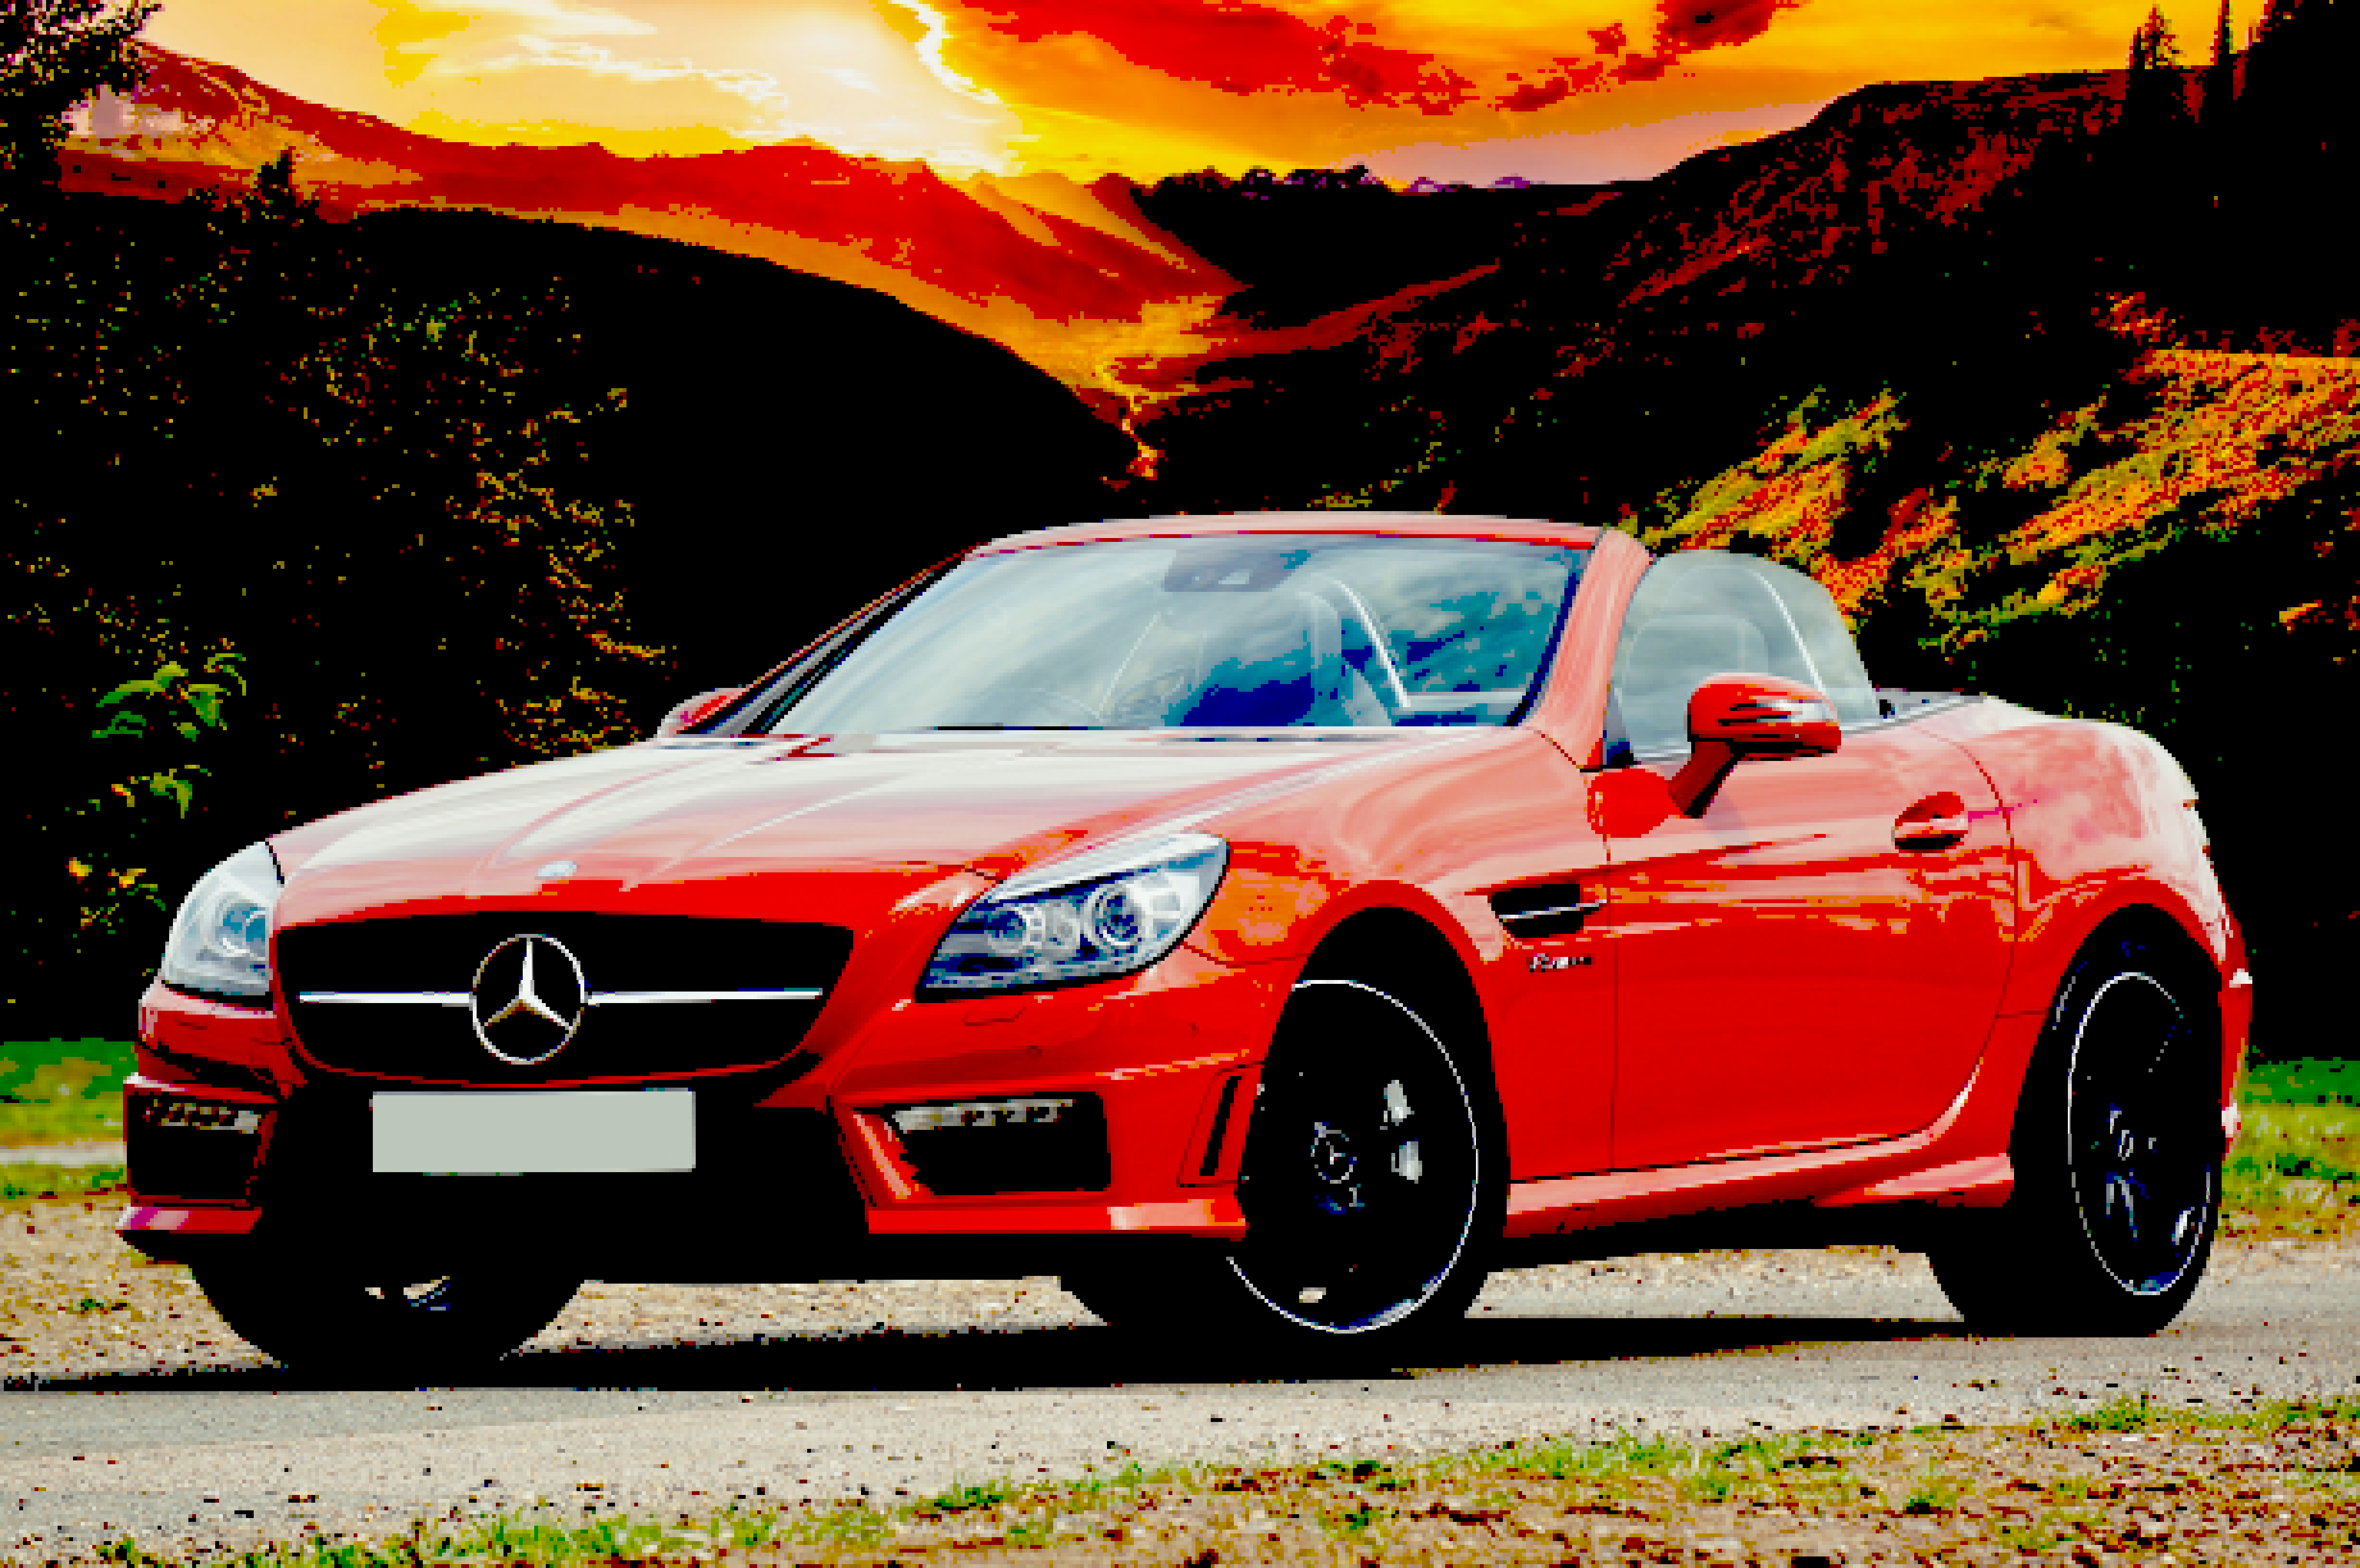

True

In [12]:
import numpy as np
import cv2
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc
from scipy import fftpack
from google.colab.patches import cv2_imshow

with open("image_0.4.xyz", "rb") as f:
    image_data = f.read()

for index, char in enumerate(image_data):
    if char == 0:
        break

metadata = image_data[:index]
metadata = metadata.decode("ascii")
data = eval(metadata)
red, green,blue = data['red'], data['green'], data['blue']
imsize = data['imsize']
thresh = data['thresh']

r_data = image_data[index+1: index+1 + red[1]]
g_data = image_data[index+1 + red[1]: index+1 + red[1] + green[1]]
b_data = image_data[index+1 + red[1] + green[1]: index+1 + red[1] + green[1] + blue[1]]

def huffman_decode(ch_data, symbol_dict):
    binary = ""
    symbol_dict = {symbol_dict[i]: i for i in symbol_dict}

    for i in ch_data:
        binary_num   = bin(i)[2:]
        binary_num = "0"*(8 - len(binary_num))+binary_num
        binary +=binary_num
    data = ""
    curr = ""
    for i in binary:
        curr+=i
        x = symbol_dict.get(curr,None)
        if x:
            curr=""
            data += x
    return data

r_matrix = huffman_decode(r_data, red[0])
g_matrix = huffman_decode(g_data, green[0])
b_matrix = huffman_decode(b_data, blue[0])

# remove garbage value. Values occuring after matrix
# ended because of 0 padding of byte.
# converts string to matrix
r_matrix = eval(r_matrix.split("]]]")[0]+"]]]")
g_matrix = eval(g_matrix.split("]]]")[0]+"]]]")
b_matrix = eval(b_matrix.split("]]]")[0]+"]]]")

# regenerate matrix by reversing run length coding
# Doing runlength encoding in zig-zag for 8X8 matrix
def run_len():
    i,j = 0,0
    up = True
    while True:
        yield (i,j)
        if i==j==7:
            break
        if up:
            if i==0 and j!=7:
                j+=1
                up = False
            elif j==7 and i!=7:
                i+=1
                up = False
            elif (j!=7 and i!=0):
                i-=1
                j+=1
        else:
            if j==0 and i!=7:
                i+=1
                up = True
            elif i==7 and j!=7:
                j+=1
                up = True
            elif (j!=0 and i!=7):
                j-=1
                i+=1
    yield 0


def decompress_block(x):
    gen = run_len()
    index = 0
    num = x[0]
    max_cnt = x[1]
    cnt = 0
    y = np.zeros((8,8))

    for i in range(8):
        for j in range(8):
            a,b = next(gen)
            y[a][b] = num
            cnt+=1
            if (cnt == max_cnt and ((i,j) != (7,7))):
                cnt=0
                index +=2
                num = x[index]
                max_cnt = x[index + 1]
    return y


def decode_channel(channel):
    fin = []
    for ind1, i in enumerate(channel):
        x = []
        for ind2, j in enumerate(i):
            x.append(decompress_block(j))
        x = np.concatenate(x, axis = 1)
        fin.append(x)
    fin = np.concatenate(fin, axis = 0)
    # trim extra bits
    fin = fin[:imsize[0],:imsize[1]]
    return fin

# Decompressing matrix with reverse run-length coding
r_channel = decode_channel(r_matrix)
g_channel = decode_channel(g_matrix)
b_channel = decode_channel(b_matrix)

def idct2(a):
    return fftpack.idct(fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

# Reconstructing Image
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        r_channel[i:(i+8),j:(j+8)] = idct2( r_channel[i:(i+8),j:(j+8)] )
        g_channel[i:(i+8),j:(j+8)] = idct2( g_channel[i:(i+8),j:(j+8)] )
        b_channel[i:(i+8),j:(j+8)] = idct2( b_channel[i:(i+8),j:(j+8)] )


# Post processing to keep the pixel values b/w [0,255]
x = cv2.merge((np.array(np.clip(b_channel, 0, 255), dtype= np.uint8),
              np.array(np.clip(g_channel, 0, 255), dtype= np.uint8),
              np.array(np.clip(r_channel, 0, 255), dtype= np.uint8)))


##Display the dct of that block
cv2_imshow(x)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(f'compressed_image_{thresh}.jpg', x)





In [ ]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0  24001      0 --:--:-- --:--:-- --:--:-- 24117


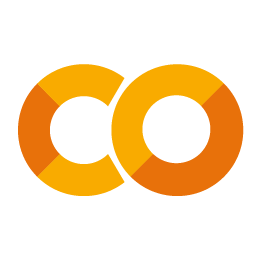

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)